#### This script will perform CRF Differences and save them as a dict -> .pkl file
####  4| maybe find the error bars? 


In [127]:
# load packages
import numpy as np 
from scipy.io   import  loadmat
from scipy import stats
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

In [3]:
NumBins = 6 # number of contrasts
NumHarms = 2 # number of harmonic data: 2F1, 4F1
NumComp = 0 # first component from RCA
NumConds = 4
diff_ax = np.arange(0,NumBins) # plot differences

In [16]:
cp1 = sns.color_palette("cubehelix",12)# dark to light
cp2 = sns.color_palette("hls",12)
sns.set_theme(context='notebook', style = 'darkgrid', palette=cp1)

In [99]:
sns.color_palette("cubehelix",12)

[(0.09047371119989064, 0.05445716110232385, 0.13852748506080714),
 (0.09969720832685408, 0.15801554750586727, 0.2709350859808844),
 (0.08217360710333568, 0.2933828584411944, 0.3056769890124602),
 (0.1273556209660727, 0.40688107540873075, 0.2510509720132212),
 (0.2859128565523805, 0.4710624660630873, 0.18738893702815024),
 (0.5189779257277026, 0.4791977979866502, 0.22113568487102592),
 (0.7191546442520655, 0.47408267612900734, 0.3799983938958308),
 (0.8256488974926798, 0.5070500942798608, 0.6257479983967315),
 (0.8172332440272755, 0.6039901042725871, 0.8417612519210355),
 (0.769116287350359, 0.7357927626253576, 0.9434086075123853),
 (0.7692547706801687, 0.8676949271654195, 0.948566973832207),
 (0.8640896943830253, 0.9544571010212727, 0.9375776402960758)]

In [77]:
# Main Directory of processed file from MatLab
#MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\AvgCRFs\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[0] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['AllCondCRF_AllSess_20240213_1141.pkl', 'F1AverageCRF_20240207_124816.pkl']
Current WD: C:\plimon\LTP_analysis\RCA_F1\AvgCRFs\AllCondCRF_AllSess_20240213_1141.pkl
Does File #1 Exist? True


In [78]:
loadData = pkl.load(open(file_path1,'rb'))
print(loadData.keys())

dict_keys(['Data', 'SubNames', 'VoiceMemo', 'DictMainKeys', 'ContLevs', 'crfLabs'])


In [79]:
data = loadData['Data']
data_labels = loadData['DictMainKeys']
SubNames = np.array(loadData['SubNames'])
note = loadData['VoiceMemo']
contrast_levels = loadData['ContLevs']
contrast_labs = loadData['crfLabs']
print(note)
NumSubs = int(len(SubNames))
print(data_labels) # labels for nr plots

['This file contains all subjects who did both sessions, avg of CRF [12x2] array, original crfs']
['attnL F1', 'attnL F2', 'attnR F1', 'attnR F2']


#### Functions

In [80]:
#sns.set_theme()
def GetDiffs(NumSubs, dictIn):
    """
    Get All post - pre amplitude differnces cross conditions and contrasts
    dictIn = key of dict data
    """
    aOut = np.zeros((NumSubs,NumBins*2)) # 55 x 12 
    for su in range(NumSubs):
        aIn = dictIn[su]
        AllDiffs = aIn[:,1] - aIn[:,0]
        aOut[su,:] = AllDiffs
    return aOut # 12x1 arry [0:6] 2f, [6:12] 4f

In [81]:
AllDiffs  = {} # 4 [nsubj * 12 array]
for co in range(NumConds):  
    AllDiffs[co] = GetDiffs(NumSubs,data[co])
    print(AllDiffs[co].shape)

(25, 12)
(25, 12)
(25, 12)
(25, 12)


#### Vis Current Data and Exclude Particpants

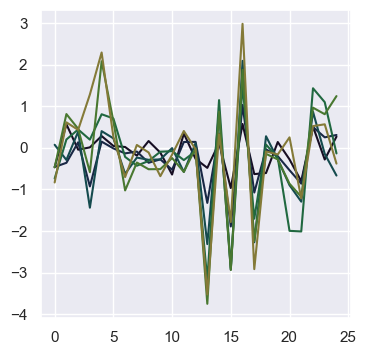

In [182]:
fig,axs = plt.subplots(1,4,figsize = (4,4), sharey=True)

f_co = 3
dIn = AllDiffs[f_co]

axs.plot(dIn[:,:6])

#### Visualize Data

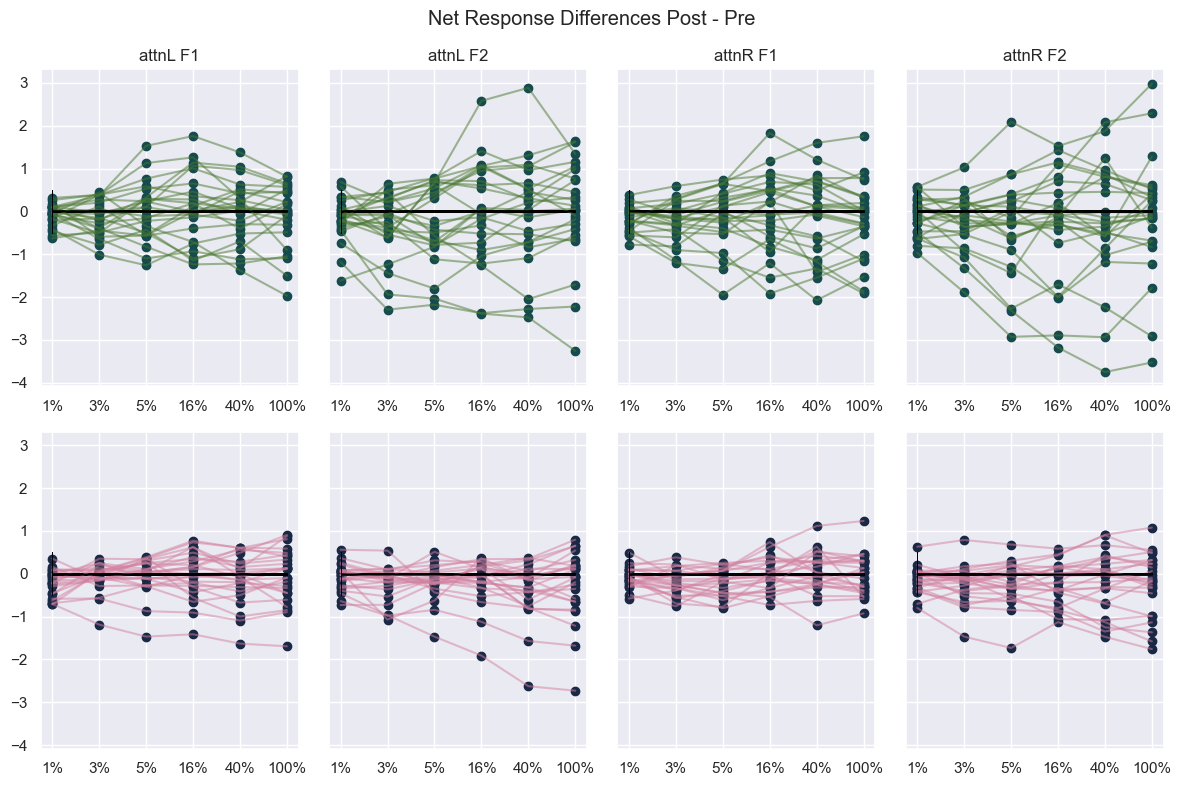

In [106]:
fig,axs = plt.subplots(2,NumConds,figsize = (12,8), sharey = True)

for co in range(NumConds):
    for su in range(NumSubs):
        axs[0,co].scatter(diff_ax,AllDiffs[co][su,:6], color = cp1[2])
        axs[0,co].plot(diff_ax,AllDiffs[co][su,:6], color = cp1[4],alpha = 1/2)
        axs[0,co].hlines(0, xmin = 0, xmax = 5, color = 'black',linewidth = 1)
        axs[0,co].vlines(0, ymin = -1/2, ymax = 1/2, color = 'black',linewidth = 1/2)

        axs[1,co].scatter(diff_ax,AllDiffs[co][su,6:],color = cp1[1])
        axs[1,co].plot(diff_ax,AllDiffs[co][su,6:],color = cp1[7],alpha = 1/2)
        axs[1,co].hlines(0, xmin = 0, xmax = 5, color = 'black',linewidth = 1)
        axs[1,co].vlines(0, ymin = -1/2, ymax = 1/2, color = 'black',linewidth = 1/2)

        axs[0,co].set_title(f'{data_labels[co]}')

        axs[0,co].set_xticks(range(len(contrast_levels)))
        axs[0,co].set_xticklabels(contrast_labs)

        axs[1,co].set_xticks(range(len(contrast_levels)))
        axs[1,co].set_xticklabels(contrast_labs)

plt.suptitle(f'Net Response Differences Post - Pre')
fig.tight_layout()
plt.show()


#### Get Average of Post - Pre Amplitudes

In [107]:
AvgDiffs = {}

for co in range(NumConds):
    AvgDiffs[co] = np.mean(AllDiffs[co],axis = 0)
print(AvgDiffs[0].shape)

(12,)


#### Visualize Average Differences 

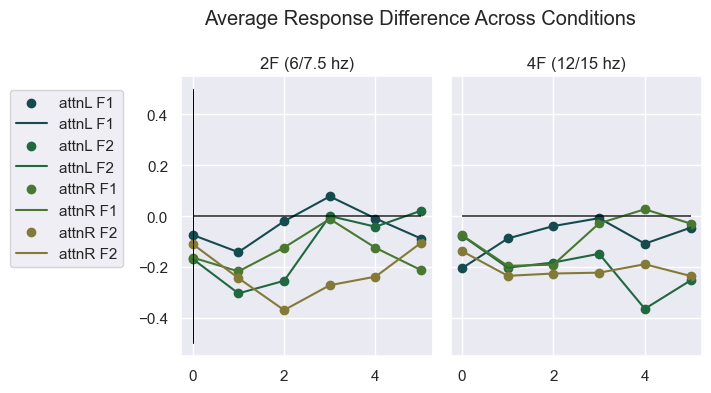

In [122]:
fig,axs = plt.subplots(1,2,figsize=(6,4),sharey=True, sharex = True)
for i in range(NumConds):
    axs[0].scatter(diff_ax,AvgDiffs[i][:6], label = f'{data_labels[i]}', color = cp1[i+2])
    axs[0].plot(diff_ax,AvgDiffs[i][:6], label = f'{data_labels[i]}', color = cp1[i+2])

    axs[1].scatter(diff_ax,AvgDiffs[i][6:], label = f'{data_labels[i]}', color = cp1[i+2])
    axs[1].plot(diff_ax,AvgDiffs[i][6:], label = f'{data_labels[i]}', color = cp1[i+2])

    axs[0].hlines(0,xmin=0,xmax=5,color='black',linewidth = 1/3)
    axs[1].hlines(0,xmin=0,xmax=5,color='black',linewidth = 1/3)
    axs[0].vlines(0,ymin=-1/2,ymax=1/2,color ='black',linewidth=1/2)

    axs[0].set_title(f'2F (6/7.5 hz)')
    axs[1].set_title(f'4F (12/15 hz)')

plt.suptitle(f'Average Response Difference Across Conditions')
plt.tight_layout()
axs[0].legend(loc = 'upper right',fontsize=9)
axs[0].legend(loc='upper right', bbox_to_anchor=(-0.2, 0.98))

#### Get Kruskal-Wallis H-test for independent samples for average data and then individual

In [144]:
g1 = AvgDiffs[0][:6]
g2 = AvgDiffs[1][:6]
g3 = AvgDiffs[2][:6]
g4 = AvgDiffs[3][:6]

result_2f = stats.kruskal(g1,g2,g3,g4)
print(result_2f)

KruskalResult(statistic=6.946666666666658, pvalue=0.07361725525556334)


In [145]:
g1 = AvgDiffs[0][6:]
g2 = AvgDiffs[1][6:]
g3 = AvgDiffs[2][6:]
g4 = AvgDiffs[3][6:]

result_4f = stats.kruskal(g1,g2,g3,g4)
print(result_4f)

KruskalResult(statistic=9.913333333333341, pvalue=0.019317383340791285)


#### Perfom Kruskall Wallis Test on Each Participant Individually

In [174]:
c2 = 0#6
for sub in range(NumSubs):
    soi = int(sub)
    print([0+c2,6+c2])
    su_data_1 = AllDiffs[0][soi][0+c2:6+c2]
    su_data_2 = AllDiffs[1][soi][0+c2:6+c2]
    su_data_3 = AllDiffs[2][soi][0+c2:6+c2]
    su_data_4 = AllDiffs[3][soi][0+c2:6+c2]

    subj_result = stats.kruskal(su_data_1,su_data_2,su_data_3,su_data_4)
    #print(subj_result[1])
    print(f'results for {SubNames[sub]} p-value: {subj_result[1]}')


[0, 6]
results for 2651 p-value: 0.001028542576828078
[0, 6]
results for 2652 p-value: 0.014988729615391624
[0, 6]
results for 2653 p-value: 0.0011447410499769526
[0, 6]
results for 2654 p-value: 0.3804562369607739
[0, 6]
results for 2655 p-value: 0.0003625666522915239
[0, 6]
results for 2657 p-value: 0.029379654942879477
[0, 6]
results for 2658 p-value: 0.0012580396543001404
[0, 6]
results for 2659 p-value: 0.1022750265469373
[0, 6]
results for 2661 p-value: 0.0012190879648795224
[0, 6]
results for 2664 p-value: 0.008537337436341217
[0, 6]
results for 2665 p-value: 0.07694897692435816
[0, 6]
results for 2666 p-value: 0.031878483214733265
[0, 6]
results for 2667 p-value: 0.013925808842245957
[0, 6]
results for 2668 p-value: 0.10936173286956657
[0, 6]
results for 2669 p-value: 0.0006092431864131826
[0, 6]
results for 2670 p-value: 0.0001713701369486345
[0, 6]
results for 2671 p-value: 0.00010973040085787255
[0, 6]
results for 2672 p-value: 0.0011447410499769459
[0, 6]
results for 2674 p

#### Save All Info From Script and Export to Computer Dir [for now]

In [119]:
DictOut={}

note = ['Cont:Post - pre responses for all conditions for all subs, sub x contrast diff']

DictOut['DiffData'] = AllDiffs
DictOut['SubNames'] = SubNames
DictOut['DictMainKeys'] = data_labels
DictOut['ContLevs'] = contrast_levels
DictOut['crfLabs'] = contrast_labs
DictOut['VoiceMemo'] = note

#### Set and Save Data Dir

In [61]:
SaveDataDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\AmpResponseDiffs\\'
FileOutName = 'PostPreResponseDifferences'
#####################################################
dnt = datetime.now()
fdnt = dnt.strftime("%Y%m%d_%H%M") # lil date seal xoxo
FileN = f'{FileOutName}_{fdnt}.pkl'

NewFilePath = os.path.join(SaveDataDir, FileN)
print(NewFilePath)

if not os.path.exists(SaveDataDir):
    os.makedirs(SaveDataDir)
    print(f'Path to Saved File is {NewFilePath}')

C:\plimon\LTP_analysis\RCA_F1\AmpResponseDiffs\PostPreResponseDifferences_20240220_1029.pkl


In [120]:
SaveFile = 'oh h-he-hell na'

if SaveFile == 'y':
    with open(NewFilePath, 'wb') as file:
        pkl.dump(DictOut, file, protocol=pkl.HIGHEST_PROTOCOL)

        print('Data Saved!!')
else:
    print('Did not save file!')


Did not save file!
